# CS 760 HW3
#### Eric Leonard, ecleonard@wisc.edu

In [127]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

In [2]:
# Read in Data
##############

emails = pd.read_csv("data/emails.csv")
emails = emails.set_index("Email No.").to_numpy()

D2z = []
with open("data/D2z.txt", "r") as f:
    for line in f:
        D2z.append(line.strip().split(" "))
D2z = np.array(D2z, dtype=np.float64)

ROC_table = np.array([[0.95, 1],
                      [0.85, 1],
                      [0.80, -1],
                      [0.70, 1],
                      [0.55, 1],
                      [0.45, -1],
                      [0.40, 1],
                      [0.30, 1],
                      [0.20, -1],
                      [0.10, -1]])


In [110]:
# HW3 Part 1 Q5
###############

def ROC_coords(data):
    num_neg = sum([1 for i in data[:,-1] if i<0])
    num_pos = sum([1 for i in data[:,-1] if i>0])
    
    TP, FP = 0, 0
    last_TP = 0
    coords = []
    coords.append([0,0])
    for i,row in enumerate(data):
        if (i > 0) and (row[0] != data[i-1][0]) and (row[1] < 0) and (TP > last_TP):
            FPR, TPR = FP / num_neg, TP/ num_pos
            coords.append([FPR, TPR])
            last_TP = TP
        if row[1] > 0:
            TP += 1
        else:
            FP += 1
    FPR, TPR = FP / num_neg, TP/ num_pos
    coords.append([FPR, TPR])
    
    return np.array(coords)

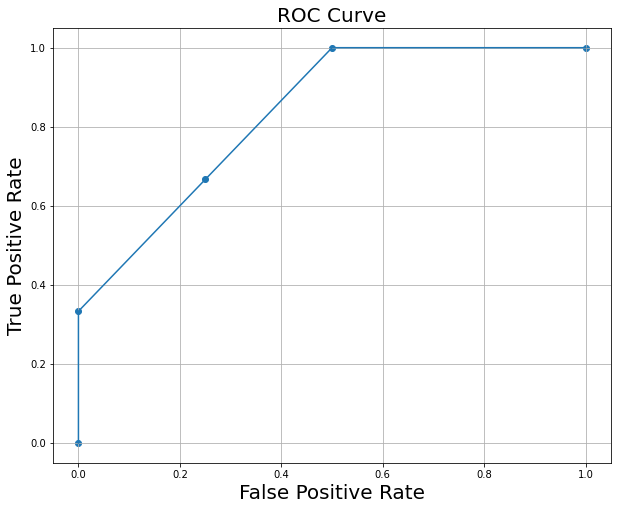

In [120]:
roc = ROC_coords(ROC_table)

fig,ax = plt.subplots(figsize=(10,8))
plt.plot(roc[:,0], roc[:,1])
plt.scatter(roc[:,0], roc[:,1])
plt.grid()
plt.xlabel("False Positive Rate",size=20)
plt.ylabel("True Positive Rate",size=20)
plt.title("ROC Curve", size=20)
plt.savefig("ROC Curve Part1.png")
None

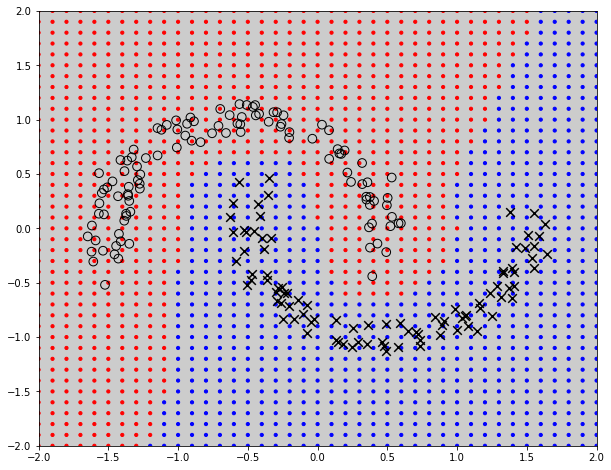

In [105]:
# HW3 Part 2 Q1
###############

# sklearn KNN "training"
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(D2z[:,:2], D2z[:,-1])

# create grid of values and make predictions with KNN
gridx, gridy = np.arange(-2,2.1,0.1), np.arange(-2,2.1,0.1)
gridX, gridY = np.meshgrid(gridx,gridy)
gridLabels = KNN.predict(np.array([gridX.ravel(), gridY.ravel()]).T)

#Seperate training data based on class
train0 = np.array([[d[0],d[1]] for d in D2z if d[-1] == 0])
train1 = np.array([[d[0],d[1]] for d in D2z if d[-1] == 1])

cmap = mpl.colors.ListedColormap(['blue', 'red'])
fig, ax = plt.subplots(figsize=(10,8))
ax.set_facecolor("0.8")

# Plot grid points
plt.scatter(gridX,gridY, s=10, c=gridLabels, cmap=cmap)
# Plot training points
plt.scatter(train0[:,0], train0[:,1], s=75, marker="x", c="k", label="Training Data y=0")
plt.scatter(train1[:,0], train1[:,1], s=75, marker="o", facecolors='none', edgecolors="k", label="Training Data y=1")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.savefig("KNN Boundary.png")
None

In [6]:
# HW3 Part 2 Q2
###############

email_subsets = [emails[1000*i:1000*i+1000, :] for i in range(5)]
for i,s in enumerate(email_subsets):
    test = s
    compliment = list(set(range(5)) - set([i]))
    train = np.concatenate(tuple([email_subsets[j] for j in compliment]), axis=0)
    KNN = KNeighborsClassifier(n_neighbors=1)
    KNN.fit(train[:,:-1],train[:,-1])
    predicted = KNN.predict(test[:,:-1])
    accuracy = accuracy_score(test[:,-1], predicted)
    precision = precision_score(test[:,-1], predicted)
    recall = recall_score(test[:,-1], predicted)
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

Accuracy: 0.825, Precision: 0.6544943820224719, Recall: 0.8175438596491228
Accuracy: 0.853, Precision: 0.6857142857142857, Recall: 0.8664259927797834
Accuracy: 0.862, Precision: 0.7212121212121212, Recall: 0.8380281690140845
Accuracy: 0.851, Precision: 0.7164179104477612, Recall: 0.8163265306122449
Accuracy: 0.775, Precision: 0.6057441253263708, Recall: 0.7581699346405228


In [121]:
# HW3 Part 2 Q3
###############

def sigmoid(x,theta):
    return 1 / (1 + np.exp(-theta.T@x))

def grad(x,theta, y):
    #return (y / sigmoid(x,theta))*x + (1-y)*sigmoid(x,theta)*x
    return x*(sigmoid(x,theta) - y)

class LogisticClassifier:
    def __init__(self, rate=0.1):
        self.rate=rate
        
    def train(self, X, Y, epochs=100):
        theta0 = np.zeros(X.shape[1])
        self.theta = theta0
        n = len(X)
        for t in range(epochs):
            self.theta -= self.rate*(-1/n)*sum([grad(x,self.theta,y) for x,y in zip(X,Y)])
        
        return self.theta
    
    def predict(self, x):
        return sigmoid(x,self.theta)

In [122]:
email_subsets = [emails[1000*i:1000*i+1000, :] for i in range(5)]
for i,s in enumerate(email_subsets):
    test = s
    test = np.concatenate((np.ones((len(test),1)),test),axis=1)
    compliment = list(set(range(5)) - set([i]))
    train = np.concatenate(tuple([email_subsets[j] for j in compliment]), axis=0)
    train = np.concatenate((np.ones((len(train),1)),train), axis=1)

    LogisticRegression = LogisticClassifier(rate=0.01)
    LogisticRegression.train(train[:,:-1], train[:,-1], epochs=150)
    predicted = LogisticRegression.predict(test[:,:-1].T)
    accuracy = accuracy_score(test[:,-1], predicted)
    precision = precision_score(test[:,-1], predicted)
    recall = recall_score(test[:,-1], predicted)
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

Accuracy: 0.285, Precision: 0.285, Recall: 1.0
Accuracy: 0.277, Precision: 0.277, Recall: 1.0
Accuracy: 0.284, Precision: 0.284, Recall: 1.0
Accuracy: 0.294, Precision: 0.294, Recall: 1.0
Accuracy: 0.306, Precision: 0.306, Recall: 1.0


In [7]:
# HW3 Part 2 Q4
###############

ks = [1,3,5,7,10]
avgs = []
for k in ks:
    accuracies = []
    for i,s in enumerate(email_subsets):
        test = s
        compliment = list(set(range(5)) - set([i]))
        train = np.concatenate(tuple([email_subsets[j] for j in compliment]), axis=0)
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN.fit(train[:,:-1],train[:,-1])
        predicted = KNN.predict(test[:,:-1])
        accuracy = accuracy_score(test[:,-1], predicted)
        accuracies.append(accuracy)
    
    average_accuracy = sum(accuracies) / len(accuracies)
    avgs.append(average_accuracy)

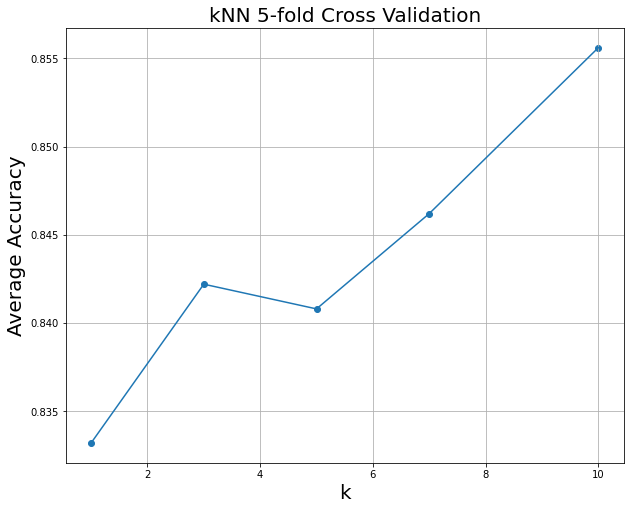

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(ks,avgs)
plt.scatter(ks,avgs)
plt.xlabel("k", size=20)
plt.ylabel("Average Accuracy", size=20)
plt.title("kNN 5-fold Cross Validation", size=20) 
plt.grid()
plt.savefig("Average Accuracy Knn.png")
None

In [104]:
np.round(avgs,3)

array([0.833, 0.842, 0.841, 0.846, 0.856])

[[0.8 0.2]
 [1.  0. ]
 [1.  0. ]
 ...
 [1.  0. ]
 [0.  1. ]
 [0.  1. ]]


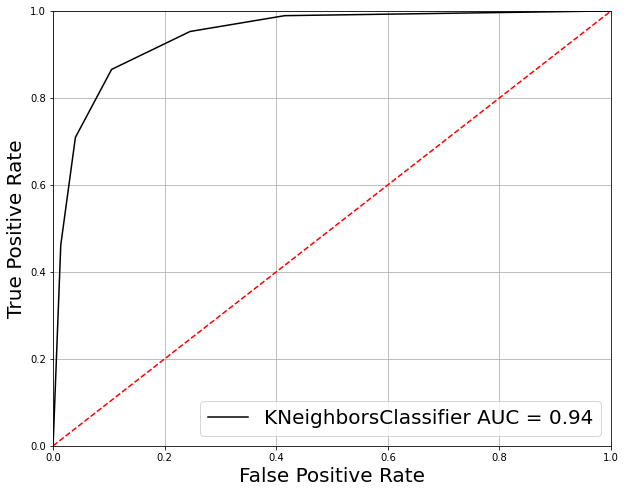

In [153]:
# HW3 Part 2 Q5
###############

X_train, X_test, y_train, y_test = train_test_split(emails[:,:-1], emails[:,-1], test_size=0.2)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)

y_scores = knn.predict_proba(X_test)
print(y_scores)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

fig,ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, 'k', label = 'KNeighborsClassifier AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize=20)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',size=20)
plt.xlabel('False Positive Rate',size=20)
plt.grid()
plt.savefig("ROC part2.png")
plt.show()